In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
#
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [2]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("UCI/Seoul Bike Sharing Demand/SeoulBikeData.csv", encoding='latin1').drop(["Date", "Holiday", "Seasons"], axis=1)

In [3]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [4]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


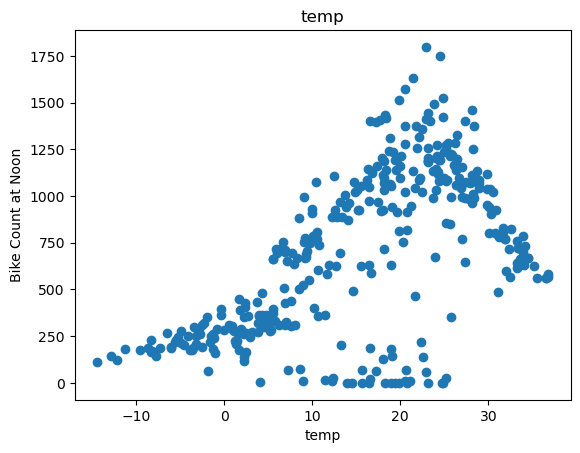

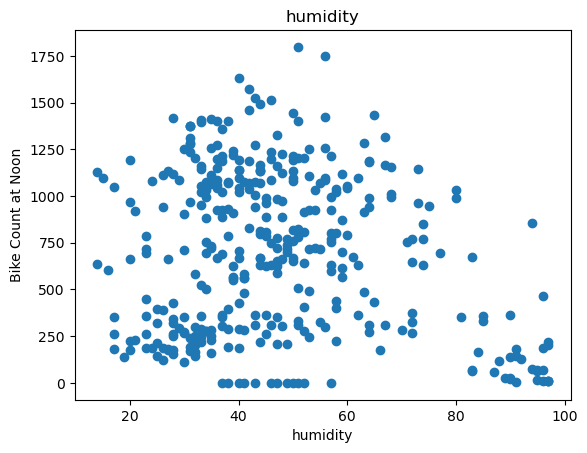

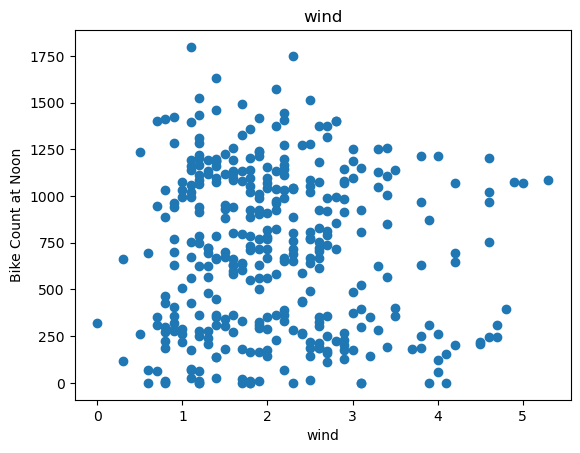

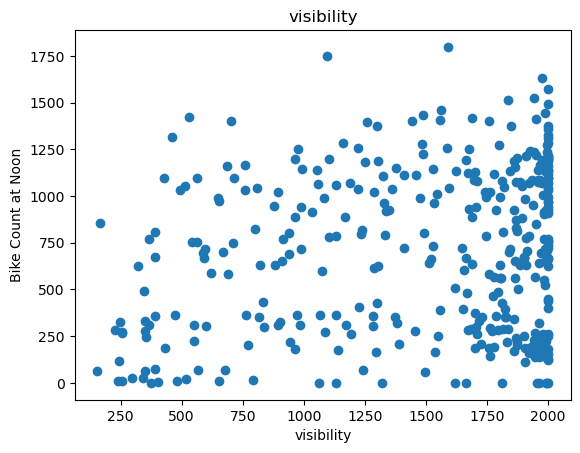

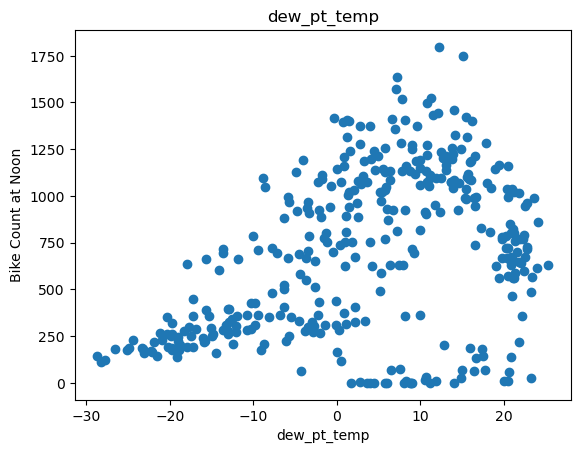

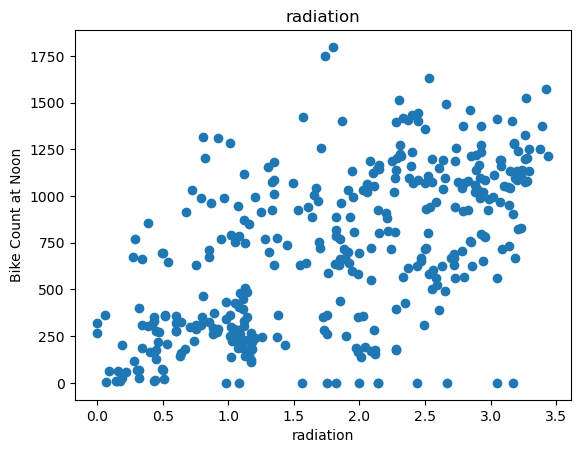

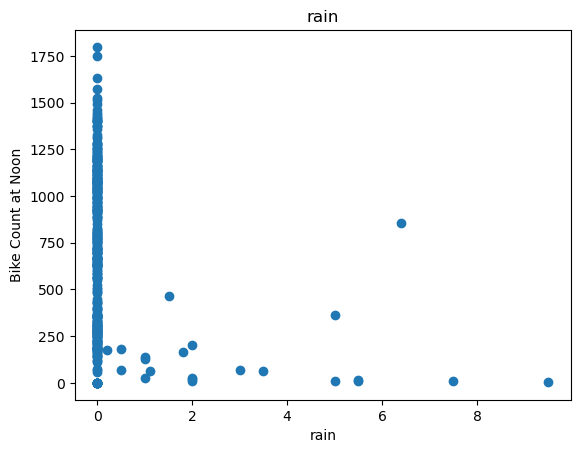

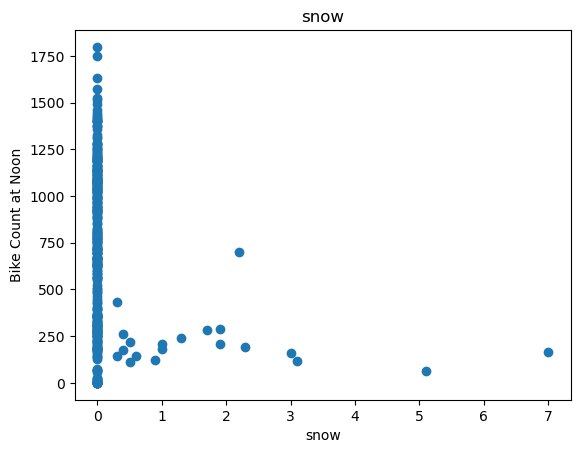

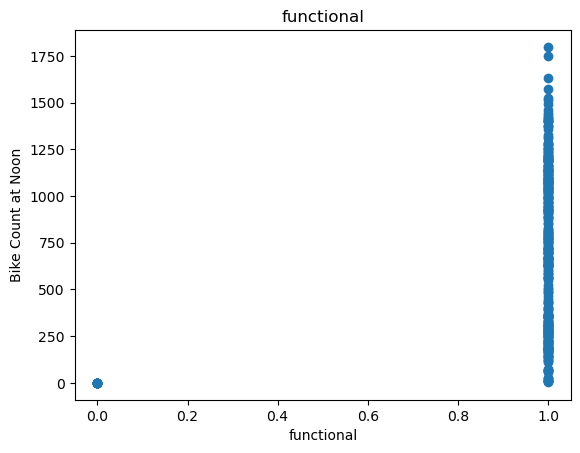

In [5]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [6]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [7]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/valid/test dataset

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [9]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [10]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [11]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [12]:
temp_reg.score(X_test_temp, y_test_temp)

0.34364569518756727

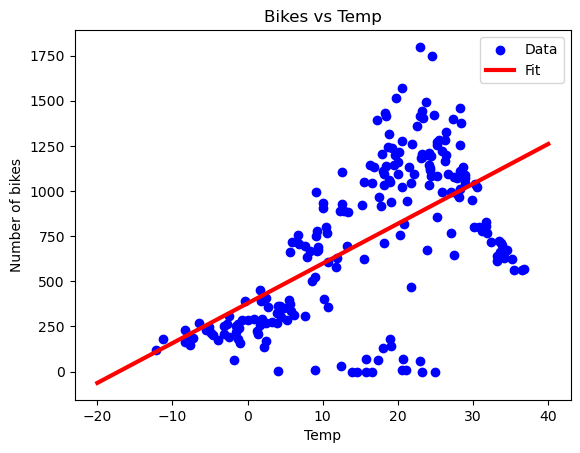

In [13]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [14]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [15]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [16]:
all_reg.score(X_test_all, y_test_all)

0.5486659634020818

In [17]:
y_pred_lr = all_reg.predict(X_test_all)

# Regression with Neural Net

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [20]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [21]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [22]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [23]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
#   verbose=0,
    epochs=10,
    validation_data=(X_val_temp, y_val_temp)
)

Epoch 1/1000
7/7 [==============================] - 2s 81ms/step - loss: 718516.0000 - val_loss: 552560.6250
Epoch 2/1000
7/7 [==============================] - 0s 17ms/step - loss: 717104.3125 - val_loss: 551547.4375
Epoch 3/1000
7/7 [==============================] - 0s 12ms/step - loss: 715770.2500 - val_loss: 550521.8125
Epoch 4/1000
7/7 [==============================] - 0s 13ms/step - loss: 714419.4375 - val_loss: 549497.9375
Epoch 5/1000
7/7 [==============================] - 0s 19ms/step - loss: 713078.3750 - val_loss: 548473.1250
Epoch 6/1000
7/7 [==============================] - 0s 12ms/step - loss: 711701.3125 - val_loss: 547460.6875
Epoch 7/1000
7/7 [==============================] - 0s 18ms/step - loss: 710354.2500 - val_loss: 546448.5000
Epoch 8/1000
7/7 [==============================] - 0s 22ms/step - loss: 709038.8125 - val_loss: 545429.3125
Epoch 9/1000
7/7 [==============================] - 0s 12ms/step - loss: 707672.1250 - val_loss: 544420.7500
Epoch 10/1000
7/7 [

7/7 [==============================] - 0s 12ms/step - loss: 545373.1250 - val_loss: 422535.0625
Epoch 150/1000
7/7 [==============================] - 0s 11ms/step - loss: 544373.6875 - val_loss: 421788.9062
Epoch 151/1000
7/7 [==============================] - 0s 12ms/step - loss: 543364.6250 - val_loss: 421048.9375
Epoch 152/1000
7/7 [==============================] - 0s 10ms/step - loss: 542391.4375 - val_loss: 420301.5938
Epoch 153/1000
7/7 [==============================] - 0s 11ms/step - loss: 541406.1875 - val_loss: 419552.9062
Epoch 154/1000
7/7 [==============================] - 0s 10ms/step - loss: 540368.1250 - val_loss: 418825.0312
Epoch 155/1000
7/7 [==============================] - 0s 11ms/step - loss: 539402.0625 - val_loss: 418085.7188
Epoch 156/1000
7/7 [==============================] - 0s 10ms/step - loss: 538420.6875 - val_loss: 417344.0000
Epoch 157/1000
7/7 [==============================] - 0s 11ms/step - loss: 537434.6250 - val_loss: 416599.7500
Epoch 158/1000
7

Epoch 223/1000
7/7 [==============================] - 0s 12ms/step - loss: 476451.0625 - val_loss: 371154.7500
Epoch 224/1000
7/7 [==============================] - 0s 9ms/step - loss: 475592.9375 - val_loss: 370512.8750
Epoch 225/1000
7/7 [==============================] - 0s 11ms/step - loss: 474736.5938 - val_loss: 369870.9062
Epoch 226/1000
7/7 [==============================] - 0s 10ms/step - loss: 473868.5000 - val_loss: 369228.1250
Epoch 227/1000
7/7 [==============================] - 0s 10ms/step - loss: 473019.7500 - val_loss: 368583.2500
Epoch 228/1000
7/7 [==============================] - 0s 10ms/step - loss: 472145.2500 - val_loss: 367942.7500
Epoch 229/1000
7/7 [==============================] - 0s 13ms/step - loss: 471310.2812 - val_loss: 367299.8125
Epoch 230/1000
7/7 [==============================] - 0s 12ms/step - loss: 470436.9688 - val_loss: 366668.8438
Epoch 231/1000
7/7 [==============================] - 0s 11ms/step - loss: 469573.8438 - val_loss: 366040.7812
Ep

Epoch 297/1000
7/7 [==============================] - 0s 14ms/step - loss: 417112.8438 - val_loss: 327079.0625
Epoch 298/1000
7/7 [==============================] - 0s 14ms/step - loss: 416349.5312 - val_loss: 326530.9062
Epoch 299/1000
7/7 [==============================] - 0s 11ms/step - loss: 415604.3125 - val_loss: 325983.6250
Epoch 300/1000
7/7 [==============================] - 0s 11ms/step - loss: 414889.0312 - val_loss: 325429.6562
Epoch 301/1000
7/7 [==============================] - 0s 11ms/step - loss: 414136.6250 - val_loss: 324881.9688
Epoch 302/1000
7/7 [==============================] - 0s 11ms/step - loss: 413387.0312 - val_loss: 324339.8125
Epoch 303/1000
7/7 [==============================] - 0s 11ms/step - loss: 412649.5000 - val_loss: 323798.8125
Epoch 304/1000
7/7 [==============================] - 0s 13ms/step - loss: 411932.5312 - val_loss: 323249.2500
Epoch 305/1000
7/7 [==============================] - 0s 11ms/step - loss: 411185.3750 - val_loss: 322709.3438
E

Epoch 371/1000
7/7 [==============================] - 0s 11ms/step - loss: 366003.7188 - val_loss: 289297.0625
Epoch 372/1000
7/7 [==============================] - 0s 11ms/step - loss: 365348.4062 - val_loss: 288823.0000
Epoch 373/1000
7/7 [==============================] - 0s 10ms/step - loss: 364713.0312 - val_loss: 288354.2188
Epoch 374/1000
7/7 [==============================] - 0s 14ms/step - loss: 364091.3125 - val_loss: 287876.2812
Epoch 375/1000
7/7 [==============================] - 0s 10ms/step - loss: 363420.9688 - val_loss: 287414.7188
Epoch 376/1000
7/7 [==============================] - 0s 10ms/step - loss: 362825.1562 - val_loss: 286938.6875
Epoch 377/1000
7/7 [==============================] - 0s 12ms/step - loss: 362173.6250 - val_loss: 286472.2188
Epoch 378/1000
7/7 [==============================] - 0s 10ms/step - loss: 361539.6250 - val_loss: 286005.5625
Epoch 379/1000
7/7 [==============================] - 0s 11ms/step - loss: 360890.0938 - val_loss: 285544.3438
E

Epoch 445/1000
7/7 [==============================] - 0s 12ms/step - loss: 321988.2812 - val_loss: 256905.1562
Epoch 446/1000
7/7 [==============================] - 0s 10ms/step - loss: 321475.4062 - val_loss: 256495.1719
Epoch 447/1000
7/7 [==============================] - 0s 10ms/step - loss: 320898.8750 - val_loss: 256091.4531
Epoch 448/1000
7/7 [==============================] - 0s 11ms/step - loss: 320361.5000 - val_loss: 255690.7656
Epoch 449/1000
7/7 [==============================] - 0s 10ms/step - loss: 319832.5938 - val_loss: 255282.6094
Epoch 450/1000
7/7 [==============================] - 0s 11ms/step - loss: 319279.3750 - val_loss: 254878.2500
Epoch 451/1000
7/7 [==============================] - 0s 10ms/step - loss: 318714.8125 - val_loss: 254484.7188
Epoch 452/1000
7/7 [==============================] - 0s 10ms/step - loss: 318182.1875 - val_loss: 254082.4062
Epoch 453/1000
7/7 [==============================] - 0s 11ms/step - loss: 317639.0938 - val_loss: 253685.5625
E

Epoch 519/1000
7/7 [==============================] - 0s 13ms/step - loss: 284197.5938 - val_loss: 229144.6094
Epoch 520/1000
7/7 [==============================] - 0s 10ms/step - loss: 283694.5312 - val_loss: 228800.5625
Epoch 521/1000
7/7 [==============================] - 0s 10ms/step - loss: 283236.0938 - val_loss: 228457.8281
Epoch 522/1000
7/7 [==============================] - 0s 9ms/step - loss: 282771.3125 - val_loss: 228107.1875
Epoch 523/1000
7/7 [==============================] - 0s 11ms/step - loss: 282284.0312 - val_loss: 227763.5938
Epoch 524/1000
7/7 [==============================] - 0s 11ms/step - loss: 281814.4688 - val_loss: 227419.4688
Epoch 525/1000
7/7 [==============================] - 0s 10ms/step - loss: 281359.0312 - val_loss: 227076.2344
Epoch 526/1000
7/7 [==============================] - 0s 11ms/step - loss: 280898.1250 - val_loss: 226736.1875
Epoch 527/1000
7/7 [==============================] - 0s 12ms/step - loss: 280426.1250 - val_loss: 226387.9531
Ep

Epoch 593/1000
7/7 [==============================] - 0s 11ms/step - loss: 251653.2188 - val_loss: 205403.9375
Epoch 594/1000
7/7 [==============================] - 0s 10ms/step - loss: 251255.9688 - val_loss: 205102.7500
Epoch 595/1000
7/7 [==============================] - 0s 10ms/step - loss: 250857.4219 - val_loss: 204809.5938
Epoch 596/1000
7/7 [==============================] - 0s 11ms/step - loss: 250441.6406 - val_loss: 204515.5469
Epoch 597/1000
7/7 [==============================] - 0s 9ms/step - loss: 250038.9844 - val_loss: 204224.5000
Epoch 598/1000
7/7 [==============================] - 0s 10ms/step - loss: 249634.2031 - val_loss: 203932.1406
Epoch 599/1000
7/7 [==============================] - 0s 23ms/step - loss: 249230.0625 - val_loss: 203641.7969
Epoch 600/1000
7/7 [==============================] - 0s 11ms/step - loss: 248840.9844 - val_loss: 203348.7500
Epoch 601/1000
7/7 [==============================] - 0s 15ms/step - loss: 248431.3906 - val_loss: 203060.5938
Ep

Epoch 667/1000
7/7 [==============================] - 0s 14ms/step - loss: 223849.0625 - val_loss: 185322.6875
Epoch 668/1000
7/7 [==============================] - 0s 15ms/step - loss: 223501.2969 - val_loss: 185073.5312
Epoch 669/1000
7/7 [==============================] - 0s 14ms/step - loss: 223136.2500 - val_loss: 184825.1406
Epoch 670/1000
7/7 [==============================] - 0s 15ms/step - loss: 222807.6875 - val_loss: 184580.9844
Epoch 671/1000
7/7 [==============================] - 0s 15ms/step - loss: 222455.6719 - val_loss: 184333.5000
Epoch 672/1000
7/7 [==============================] - 0s 11ms/step - loss: 222119.6719 - val_loss: 184093.3906
Epoch 673/1000
7/7 [==============================] - 0s 12ms/step - loss: 221773.9219 - val_loss: 183849.5625
Epoch 674/1000
7/7 [==============================] - 0s 14ms/step - loss: 221443.8594 - val_loss: 183603.5938
Epoch 675/1000
7/7 [==============================] - 0s 17ms/step - loss: 221086.8281 - val_loss: 183359.7500
E

Epoch 741/1000
7/7 [==============================] - 0s 15ms/step - loss: 200276.5469 - val_loss: 168701.5781
Epoch 742/1000
7/7 [==============================] - 0s 14ms/step - loss: 199990.3906 - val_loss: 168505.3906
Epoch 743/1000
7/7 [==============================] - 0s 9ms/step - loss: 199705.4062 - val_loss: 168301.1719
Epoch 744/1000
7/7 [==============================] - 0s 11ms/step - loss: 199406.6719 - val_loss: 168099.0781
Epoch 745/1000
7/7 [==============================] - 0s 12ms/step - loss: 199125.1094 - val_loss: 167901.1406
Epoch 746/1000
7/7 [==============================] - 0s 11ms/step - loss: 198832.1094 - val_loss: 167701.4531
Epoch 747/1000
7/7 [==============================] - 0s 11ms/step - loss: 198552.7812 - val_loss: 167505.8750
Epoch 748/1000
7/7 [==============================] - 0s 15ms/step - loss: 198253.3750 - val_loss: 167304.5469
Epoch 749/1000
7/7 [==============================] - 0s 12ms/step - loss: 197966.8281 - val_loss: 167102.5312
Ep

Epoch 815/1000
7/7 [==============================] - 0s 10ms/step - loss: 180624.2188 - val_loss: 155343.8438
Epoch 816/1000
7/7 [==============================] - 0s 10ms/step - loss: 180367.2031 - val_loss: 155185.5781
Epoch 817/1000
7/7 [==============================] - 0s 10ms/step - loss: 180144.4375 - val_loss: 155026.3750
Epoch 818/1000
7/7 [==============================] - 0s 11ms/step - loss: 179890.1406 - val_loss: 154874.6094
Epoch 819/1000
7/7 [==============================] - 0s 11ms/step - loss: 179653.6250 - val_loss: 154718.5000
Epoch 820/1000
7/7 [==============================] - 0s 10ms/step - loss: 179418.4219 - val_loss: 154562.4375
Epoch 821/1000
7/7 [==============================] - 0s 11ms/step - loss: 179187.9219 - val_loss: 154410.7031
Epoch 822/1000
7/7 [==============================] - 0s 10ms/step - loss: 178945.2344 - val_loss: 154255.0469
Epoch 823/1000
7/7 [==============================] - 0s 11ms/step - loss: 178722.6406 - val_loss: 154107.2969
E

Epoch 889/1000
7/7 [==============================] - 0s 11ms/step - loss: 164581.7188 - val_loss: 145127.8125
Epoch 890/1000
7/7 [==============================] - 0s 11ms/step - loss: 164384.1875 - val_loss: 145012.4062
Epoch 891/1000
7/7 [==============================] - 0s 11ms/step - loss: 164190.3594 - val_loss: 144896.1250
Epoch 892/1000
7/7 [==============================] - 0s 10ms/step - loss: 163998.4062 - val_loss: 144777.0625
Epoch 893/1000
7/7 [==============================] - 0s 10ms/step - loss: 163803.6094 - val_loss: 144659.7188
Epoch 894/1000
7/7 [==============================] - 0s 11ms/step - loss: 163621.9844 - val_loss: 144544.7031
Epoch 895/1000
7/7 [==============================] - 0s 10ms/step - loss: 163427.5469 - val_loss: 144431.9375
Epoch 896/1000
7/7 [==============================] - 0s 10ms/step - loss: 163253.5781 - val_loss: 144315.2500
Epoch 897/1000
7/7 [==============================] - 0s 9ms/step - loss: 163046.7031 - val_loss: 144205.9688
Ep

Epoch 963/1000
7/7 [==============================] - 0s 11ms/step - loss: 151869.9688 - val_loss: 137851.5000
Epoch 964/1000
7/7 [==============================] - 0s 12ms/step - loss: 151720.7969 - val_loss: 137773.6562
Epoch 965/1000
7/7 [==============================] - 0s 10ms/step - loss: 151573.0000 - val_loss: 137695.8750
Epoch 966/1000
7/7 [==============================] - 0s 11ms/step - loss: 151412.6094 - val_loss: 137618.4531
Epoch 967/1000
7/7 [==============================] - 0s 11ms/step - loss: 151285.2812 - val_loss: 137540.2656
Epoch 968/1000
7/7 [==============================] - 0s 10ms/step - loss: 151115.6719 - val_loss: 137464.0625
Epoch 969/1000
7/7 [==============================] - 0s 10ms/step - loss: 150976.0781 - val_loss: 137384.0625
Epoch 970/1000
7/7 [==============================] - 0s 11ms/step - loss: 150825.5469 - val_loss: 137305.7969
Epoch 971/1000
7/7 [==============================] - 0s 12ms/step - loss: 150681.3438 - val_loss: 137226.4062
E

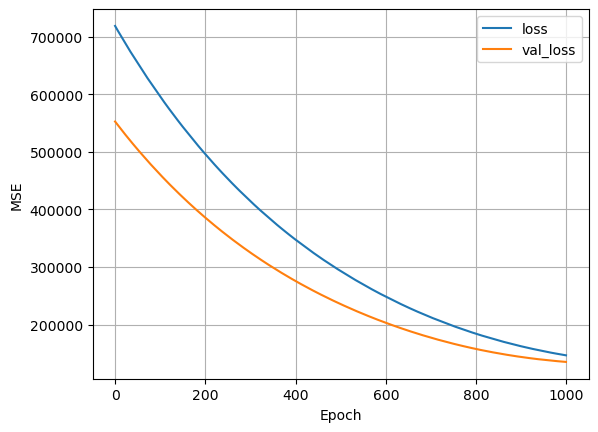

In [24]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


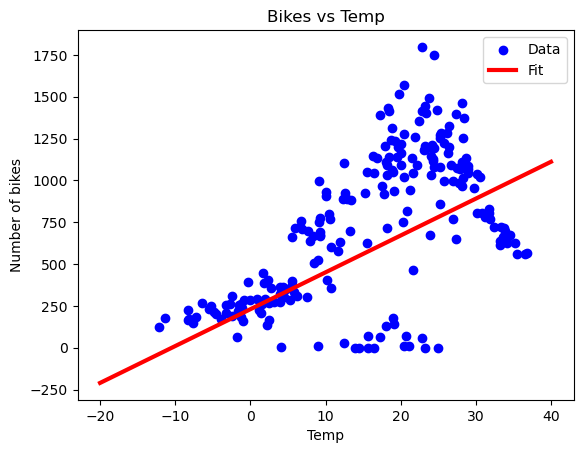

In [25]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [26]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [27]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    # verbose=0, 
    epochs=100
)

Epoch 1/100
7/7 [==============================] - 2s 47ms/step - loss: 719019.1250 - val_loss: 553412.5000
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 718797.0000 - val_loss: 553233.8750
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 718559.5625 - val_loss: 553019.3125
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 718239.0625 - val_loss: 552723.3125
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 717819.5000 - val_loss: 552321.9375
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 717234.2500 - val_loss: 551772.0000
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 716481.8125 - val_loss: 551038.8750
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 715455.0625 - val_loss: 550087.3125
Epoch 9/100
7/7 [==============================] - 0s 12ms/step - loss: 714111.7500 - val_loss: 548849.7500
Epoch 10/100
7/7 [==========

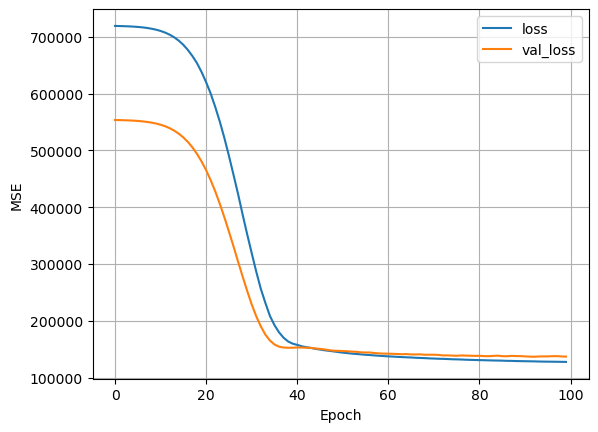

In [28]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


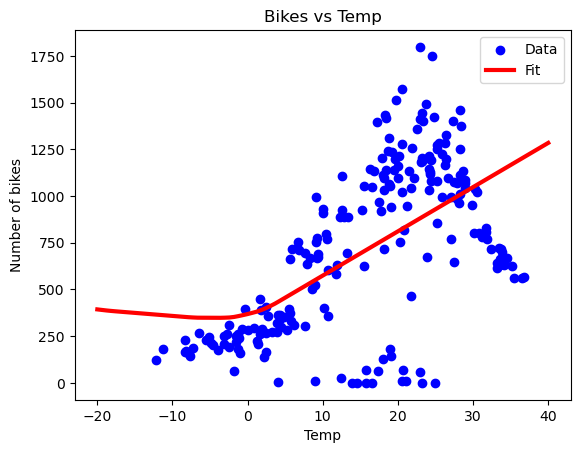

In [29]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [30]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [31]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [32]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    # verbose=0, 
    epochs=100
)

Epoch 1/100
7/7 [==============================] - 2s 53ms/step - loss: 672604.3750 - val_loss: 661322.8750
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 672276.2500 - val_loss: 660985.1875
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 671897.6250 - val_loss: 660630.9375
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 671505.8750 - val_loss: 660224.0625
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 671050.8125 - val_loss: 659739.6250
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 670497.5625 - val_loss: 659161.3750
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 669852.4375 - val_loss: 658467.3125
Epoch 8/100
7/7 [==============================] - 0s 12ms/step - loss: 669072.5625 - val_loss: 657649.6250
Epoch 9/100
7/7 [==============================] - 0s 12ms/step - loss: 668155.9375 - val_loss: 656673.7500
Epoch 10/100
7/7 [==========

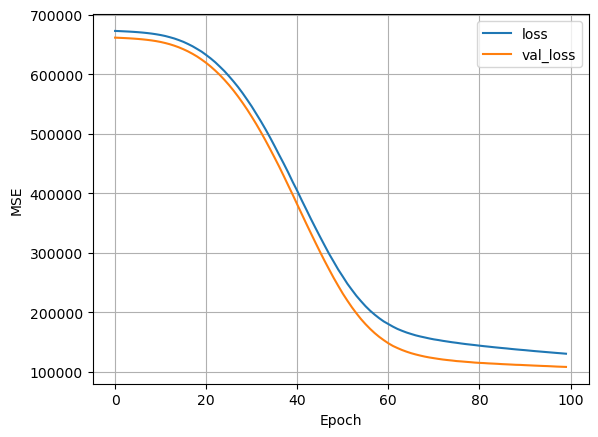

In [33]:
plot_loss(history)

In [34]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 3ms/step


In [35]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [36]:
MSE(y_pred_lr, y_test_all)

82239.89745527334

In [37]:
MSE(y_pred_nn, y_test_all)

108867.59756626487

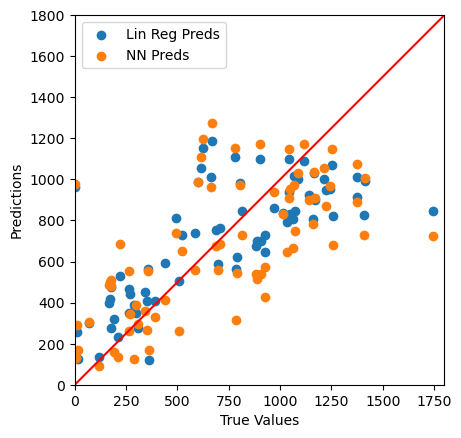

In [38]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")